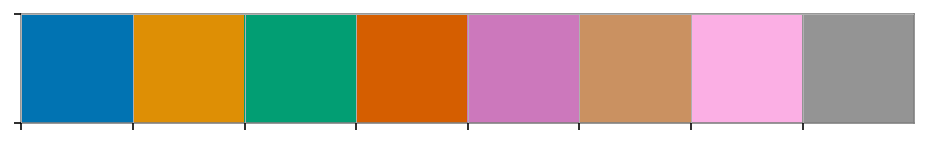

In [4]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import gwsurrogate
from scipy.interpolate import InterpolatedUnivariateSpline as spline
import scipy.integrate as integrate

import seaborn as sns

cp = sns.color_palette('colorblind', 8)
sns.palplot(cp) 
plt.show()

from tqdm import tqdm

import lal

import numexpr as ne
#import pyfftw

from gwtools import gwutils as gwu

from bilby.core.utils import nfft, infft

In [5]:
sur = gwsurrogate.LoadSurrogate('NRHybSur3dq8')
trunc_sur = gwsurrogate.LoadSurrogate('../TruncatedSurrogate/NRHybSur3dq8.h5')

/home/carl-johan.haster/.conda/envs/WF_marg_igwn-py37/lib/python3.7/site-packages/gwsurrogate/new/saveH5Object.py:106: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  v = item.value


Loaded NRHybSur3dq8 model
Loaded NRHybSur3dq8 model


In [6]:
# --------------------------------------------------------------------------
def spline_interp(newX, oldX, oldY):
    if len(oldY) != len(oldX):
        raise Exception('Lengths dont match.')

    if np.min(newX) < np.min(oldX) or np.max(newX) > np.max(oldX):
        print (newX[0], oldX[0], newX[-1], oldX[-1])
        raise Exception('Trying to extrapolate, disabled for now')

    newY = spline(oldX, oldY, ext=1)(newX)      # returns 0 when extrapolating
    return newY

def spline_interp_ext0(newX, oldX, oldY):
    if len(oldY) != len(oldX):
        raise Exception('Lengths dont match.')

    newY = spline(oldX, oldY, ext='zeros')(newX)      # returns 0 when extrapolating
    return newY

# --------------------------------------------------------------------------
def interpolate_coorbital_frame_data(t_sparse, hCoOrb_sparse, t_new):
    hCoOrb = {}
    for key in hCoOrb_sparse.keys():
        data = hCoOrb_sparse[key]
        if np.iscomplexobj(data):
            hCoOrb[key] = \
                spline_interp(t_new, t_sparse, np.real(data)) \
                +1.j*spline_interp(t_new, t_sparse, np.imag(data))
        else:
            hCoOrb[key] = spline_interp(t_new, t_sparse, data)
    return hCoOrb  

#-----------------------------------------------------------------------------
def transform_to_coorbital_frame(t, hdict):
    """ Transforms from inertial frame to coorbital frame.

    Returns coorbital frame waveform modes as a dictionary, hCoOrb_dict.
    Usage:
        Amp_l2m2 = hCoOrb_dict['Amp_l2m2']
        phi_l2m2 = hCoOrb_dict['phi_l2m2']
        hCoOrb_l3m1 = hCoOrb_dict['hCoOrb_l3m1']    # similar for all other modes
    """

    h_22 = hdict[(2,2)]
    Amp_22 = np.abs(h_22)
    phi_22 = -np.unwrap(np.angle(h_22))

    # save coorbital frame strain as a dict
    hCoOrbdict = {}
    hCoOrbdict['Amp_l2m2'] = Amp_22
    hCoOrbdict['phi_l2m2'] = phi_22

    
    #plt.figure(figsize=(12,8))
    for mode in hdict.keys():
        
        l,m = mode
        if not (l==2 and m==2):     # for (2,2) mode we save Amp,phase instead
            hlm = hdict[(l,m)]
            hCoOrbdict['hCoOrb_l%dm%d'%(l,m)] = hlm*np.exp(1j*m*phi_22/2.)
            #print(l,m, hCoOrbdict['hCoOrb_l%dm%d'%(l,m)])
            #plt.plot((hlm*np.exp(1j*m*phi_22/2.)).real, label=str(l)+' '+str(m)+' real')
            #plt.plot((hlm*np.exp(1j*m*phi_22/2.)).imag, label=str(l)+' '+str(m)+' imag')
            #plt.plot((hlm).real, label=str(l)+' '+str(m)+' real')
            #plt.plot((hlm).imag, label=str(l)+' '+str(m)+' imag')
            #plt.legend()
            #plt.show()
            
            #modePhase = np.unwrap(np.angle((hlm)))/m
            #plt.plot(modePhase, label=str(l)+' '+str(m), c=cp[m])
    #plt.legend()
    #plt.show()
                
    # Set initial phase to zero
    hCoOrbdict['phi_l2m2'] -= hCoOrbdict['phi_l2m2'][0]

    if np.max(np.abs((h_22*np.exp(1j*2*phi_22/2.)).imag)) > 1e-6:
        raise Exception('Imag part of 2,2 mode in coorbital frame should be 0 for nonprecessing cases.')

    return hCoOrbdict

# --------------------------------------------------------------------------
def transform_to_inertial_frame(hCoOrbdict):
    """ Transforms from coorbital frame to inertial frame.
    """
    hdict = {}
    phi22 = hCoOrbdict['phi_l2m2']
    hdict[(2,2)] = hCoOrbdict['Amp_l2m2'] * np.exp(-1j*phi22)
    for key in hCoOrbdict.keys():
        if key[:2] == "hC":
            l = int(key.split('_l')[-1].split('m')[0])
            m = int(key.split('m')[-1])
            hdict[(l,m)] = hCoOrbdict[key]*np.exp(-1j*m*phi22/2.)
            
    return hdict 

# --------------------------------------------------------------------------
def evaluate_surrogates(M, q, chi1, chi2, dist_mpc, f_ref, f_low, dt):
    
    # evaluate waveform modes for full surrogate and transform to coorbital frame
    t, hdict, _ = sur(q, chi1, chi2, dt=dt, f_low=f_low, f_ref=f_ref, \
        dist_mpc=dist_mpc, M=M, units='mks')
    hCoOrbdict = transform_to_coorbital_frame(t, hdict)
    
    # similarly, evaluate truncated surrogate and transform to coorbital frame
    t_trunc, hdict_trunc, _ = trunc_sur(q, chi1, chi2, dt=dt, f_low=f_low, \
        f_ref=f_ref, dist_mpc=dist_mpc, M=M, units='mks')
    hCoOrbdict_trunc = transform_to_coorbital_frame(t_trunc, hdict_trunc)
    
    # interpolate onto a common time array
    # extra caution to avoid extrapolation
    times = np.arange(max(t[1], t_trunc[1]), min(t[-2], t[-2]), dt)  
    hCoOrbdict = interpolate_coorbital_frame_data(t, hCoOrbdict, times)
    hCoOrbdict_trunc = interpolate_coorbital_frame_data(t_trunc, hCoOrbdict_trunc, times)
    
    # Set initial phase to zero
    hCoOrbdict['phi_l2m2'] -= hCoOrbdict['phi_l2m2'][0]
    hCoOrbdict_trunc['phi_l2m2'] -= hCoOrbdict_trunc['phi_l2m2'][0]
    
    return times, hCoOrbdict, hCoOrbdict_trunc

# --------------------------------------------------------------------------
def get_uniform_in_orbits_times(t, phi_orb, PTS_PER_ORBIT=5):
    """
    returns sparse time array such that there are PTS_PER_ORBIT points
    in each orbit.
    """
    # get number of orbits
    n_orbits = int(abs((phi_orb[-1] - phi_orb[0])/(2*np.pi)))

    # get sparse times such that there are PTS_PER_ORBIT points in each orbit
    n_pts = int(n_orbits*PTS_PER_ORBIT)
    phi_orb_sparse = np.linspace(phi_orb[0], phi_orb[-1], n_pts)
    t_sparse = np.interp(phi_orb_sparse, phi_orb, t)

    return t_sparse

# --------------------------------------------------------------------------
def find_sparse_time_indecies(t, phi_orb, m_max=5, PTS_PER_ORBIT=5):
    """
    returns sparse time index array for each m-mode such that there are PTS_PER_ORBIT points
    in each orbit.
    """
    idx_sparse_list = [None]*(m_max+1)
    
    for m in range(1, m_max+1):
        n_orbits = int(abs(m*(phi_orb[-1] - phi_orb[0])/(2*np.pi)))
        n_pts = int(n_orbits*PTS_PER_ORBIT)
        phi_orb_sparse = np.linspace(phi_orb[0], phi_orb[-1], n_pts)
        t_sparse = np.interp(phi_orb_sparse, phi_orb, t)
        
        # get indices of times that are closest to t_sparse
        # NOTE: We could downsample by interpolating using splines. But if the
        # data becomes very long, this becomes expensive. So, instead we just 
        # find the incdices of times that are closest to t_sparse, which is just as 
        # valid a way to downsample, but very cheap!
        idx_sparse_withPossibleDuplicates_andLastIndex = np.searchsorted(t, t_sparse)
        idx_sparse_withPossibleDuplicates = \
        idx_sparse_withPossibleDuplicates_andLastIndex[np.less(idx_sparse_withPossibleDuplicates_andLastIndex, len(t))]
        # we also don't include the last index, since that breaks the array picks 
        # ie one can't pick out index 1023 from an array of length 1023
        
        # The indecies sometimes have duplicate values at late times (ie past the ringdown)
        # The line below then removes any duplicate indecies from the array
        idx_sparse = np.array(list(dict.fromkeys(idx_sparse_withPossibleDuplicates.tolist())))
        
        idx_sparse_list[m] = idx_sparse
        if m == 1:
            idx_sparse_list[0] = idx_sparse
    
    return idx_sparse_list

# --------------------------------------------------------------------------
def add_sparse_noise_to_data_piece(times, data, data_trunc, idx_sparse):
    
    sparse_data_diff = data[idx_sparse] - data_trunc[idx_sparse]
    
    sparse_data_scatter_real = np.random.normal(0, np.abs(sparse_data_diff.real))#*np.sign(sparse_data_diff.real)
    interp_sparse_data_scatter_real = spline_interp_ext0(times, times[idx_sparse], \
                                                         np.abs(sparse_data_scatter_real)*np.sign(sparse_data_diff.real))
    
    data_marg = data.real + interp_sparse_data_scatter_real
    
    if np.iscomplexobj(sparse_data_diff):
        sparse_data_scatter_imag = np.random.normal(0, np.abs(sparse_data_diff.imag))
        interp_sparse_data_scatter_imag = spline_interp_ext0(times, times[idx_sparse], \
                                                         np.abs(sparse_data_scatter_imag)*np.sign(sparse_data_diff.imag))
        
        data_marg = data_marg + 1j*(data.imag + interp_sparse_data_scatter_imag)
        
    return data_marg
        
# --------------------------------------------------------------------------
def add_noise_to_data_piece(data, data_trunc, idx_sparse):
    # Add Gaussian noise with sigma given by the diff
    # FIXME: idx_sparse is not used for now
    data_diff = data - data_trunc
    data_marg = data.real + np.random.normal(0, np.abs(data_diff.real))
    if np.iscomplexobj(data_diff):
        data_marg = data_marg + 1j*(data.imag + np.random.normal(0, np.abs(data_diff.imag)))
        
    #plt.plot(data_marg.real, label='real')
    #plt.plot(data_marg.imag, label='imag')
    #plt.legend()
    #plt.show()
    return data_marg

# --------------------------------------------------------------------------
def align_orbital_phase(hdict):
    init_orbphase = -np.angle(hdict[(2,2)][0])/2
    for mode in hdict.keys():
        l,m = mode
        hdict[(l,m)] = hdict[(l,m)] * np.exp(1j*m*init_orbphase)
    return hdict

# --------------------------------------------------------------------------
def NRHybSur3dq8_marg(times_from_outside, M, q, chi1, chi2, dist_mpc=400, f_ref=20, f_low=20, \
        sampling_frequency=4096., incl=0, phi_ref=0, PtsPerOrbit=5):

    dt = 1./sampling_frequency
    
    # Get surrogate and truncated surrogate in coorbital frame
    times, hCoOrbdict, hCoOrbdict_trunc \
        = evaluate_surrogates(M, q, chi1, chi2, dist_mpc, f_ref, f_low, dt)
    
    #P.plot(times, hCoOrbdict['phi_l2m2'])
    #P.plot(times, hCoOrbdict_trunc['phi_l2m2'], '--')
    
    # use orbital phase to get sparse times such that there are 5 points per orbit
    # FIXME: This will oversample the post ringdown, so throw those away
    phi_orb = hCoOrbdict['phi_l2m2']/2
    t_sparse = get_uniform_in_orbits_times(times, phi_orb, PTS_PER_ORBIT=5)
    
    # get indices of times that are closest to t_sparse
    # NOTE: We could downsample by interpolating using splines. But if the
    # data becomes very long, this becomes expensive. So, instead we just 
    # find the incdices of times that are closest to t_sparse, which is just as 
    # valid a way to downsample, but very cheap!
    idx_sparse = np.searchsorted(times, t_sparse)
    
    idx_sparse_list = find_sparse_time_indecies(times, phi_orb, m_max=5, PTS_PER_ORBIT=PtsPerOrbit)
    
    #print(idx_sparse, idx_sparse.shape)
    #print(idx_sparse_list)

    # Get marginalized coorbital frame data
    hCoOrbdict_marg = {}
    hCoOrbdict_margSparse = {}
    for key in hCoOrbdict.keys():
        data = hCoOrbdict[key]
        data_trunc = hCoOrbdict_trunc[key]
        m = int(key.split('m')[-1])
        #print(key, m)
        hCoOrbdict_marg[key] = add_noise_to_data_piece(data, data_trunc, idx_sparse)
        hCoOrbdict_margSparse[key] = add_sparse_noise_to_data_piece(times, data, data_trunc, idx_sparse_list[m])
    # Set initial phase to zero after marginalization
    hCoOrbdict_marg['phi_l2m2'] -= hCoOrbdict_marg['phi_l2m2'][0]
    hCoOrbdict_margSparse['phi_l2m2'] -= hCoOrbdict_margSparse['phi_l2m2'][0]
    
    # Transform to inertial frame
    hdict = transform_to_inertial_frame(hCoOrbdict)
    hdict_marg = transform_to_inertial_frame(hCoOrbdict_marg)
    hdict_margSparse = transform_to_inertial_frame(hCoOrbdict_margSparse)
    
    # Align initial orbital phase for plots
    hdict = align_orbital_phase(hdict)
    hdict_marg = align_orbital_phase(hdict_marg)
    hdict_margSparse = align_orbital_phase(hdict_margSparse)
    
    #P.plot(times, hdict[(2,2)])
    #P.plot(times, hdict_marg[(2,2)])

    # project modes following LAL convention
    h = sur._mode_sum(hdict, incl, np.pi/2 - phi_ref, fake_neg_modes=True)
    h_marg = sur._mode_sum(hdict_marg, incl, np.pi/2 - phi_ref, fake_neg_modes=True)
    h_margSparse = sur._mode_sum(hdict_margSparse, incl, np.pi/2 - phi_ref, fake_neg_modes=True)
    
    beginning_time = times[0]
    twoOrbitsAfter_beginning_time = times[idx_sparse_list[0][2*PtsPerOrbit]]
    SeventyFiveM = 75.*lal.MTSUN_SI*M
    HundredM = 100.*lal.MTSUN_SI*M
    
    h_Plancked = gwu.windowWaveform(times, h, beginning_time, twoOrbitsAfter_beginning_time, SeventyFiveM, HundredM, windowType="planck")
    h_marg_Plancked = gwu.windowWaveform(times, h_marg, beginning_time, twoOrbitsAfter_beginning_time, SeventyFiveM, HundredM, windowType="planck")
    h_margSparse_Plancked = gwu.windowWaveform(times, h_margSparse, beginning_time, twoOrbitsAfter_beginning_time, SeventyFiveM, HundredM, windowType="planck")
    
    time_diff = len(times_from_outside) - len(times)
    
    if time_diff > 0:
        # if the waveform is shorter, zero pad to end
        h_Plancked = np.pad(h_Plancked, (0, time_diff), 'constant')
        h_marg_Plancked = np.pad(h_marg_Plancked, (0, time_diff), 'constant')
        h_margSparse_Plancked = np.pad(h_margSparse_Plancked, (0, time_diff), 'constant')
    elif time_diff < 0:
        # if the waveform is longer, remove from inspiral
        h_Plancked = h_Plancked[-time_diff:]
        h_marg_Plancked = h_marg_Plancked[-time_diff:]
        h_margSparse_Plancked = h_margSparse_Plancked[-time_diff:]
        
    ind_t0 = np.where(times>=0)[0][0]
    
    h_Plancked = np.roll(h_Plancked, len(h_Plancked)-ind_t0)
    h_marg_Plancked = np.roll(h_marg_Plancked, len(h_marg_Plancked)-ind_t0)
    h_margSparse_Plancked = np.roll(h_margSparse_Plancked, len(h_margSparse_Plancked)-ind_t0)

    return times, h_Plancked, h_marg_Plancked, h_margSparse_Plancked

# --------------------------------------------------------------------------
def simple_mismatch(h, x):
    """ Computes Mismatch without phase and time shift.
    h is Complex target waveform.
    x is Complex template waveform.
    Step size should be constant as we are approximating an intergral by a sum.
    """
    norm_h =  np.sqrt(np.real(np.sum(h*np.conj(h))))
    norm_x =  np.sqrt(np.real(np.sum(x*np.conj(x))))
    overlap = np.abs(np.sum(x*np.conj(h))/norm_h/norm_x)
    return 1 - overlap 

# -------------------------------------------------------------------------
def set_logticks(fig, ax, given_xticks=None):
    """ For histograms we use linear scale x but do np.log10 on the data.
        So, here we replace the xticks from x to 10^x. We only pick those
        x that are integers. Then add minor ticks with log scaling.
    """

    if given_xticks is not None:
        ax.set_xticks(given_xticks)

    old_xticks = ax.get_xticks()
    new_xtickLocs = []
    new_xtickLabels = []
    for old_xt in old_xticks:
        if old_xt%1 == 0:
            new_xt = int(old_xt)
            new_xtickLocs.append(new_xt)
            new_xtickLabels.append('$10^{%d}$'%new_xt)

    # reset major tick labels
    ax.set_xticks(new_xtickLocs)
    ax.set_xticklabels(new_xtickLabels)

    # add minor ticks with log scaling
    minor_tickLocs = np.array([])
    tmp_int = min(new_xtickLocs)
    while tmp_int < max(new_xtickLocs):
        minor_tickLocs = np.append(minor_tickLocs, \
            np.log10(np.arange(1,10,1)*10**(tmp_int)))
        tmp_int += 1
    minor_locator = mpl.ticker.FixedLocator(minor_tickLocs)
    ax.xaxis.set_minor_locator(minor_locator)


# ------------------------------------------------------------------------
def PlotHist(ax, data, binsize, label=None, color='b', lw=1, ls='solid', zorder=2):
    ax.hist(np.log10(np.abs(data)+1e-13), bins=binsize, \
        color=color, label=label, histtype='step', lw=lw, ls=ls, zorder=zorder)

100%|██████████| 1000/1000 [12:13<00:00,  1.36it/s]


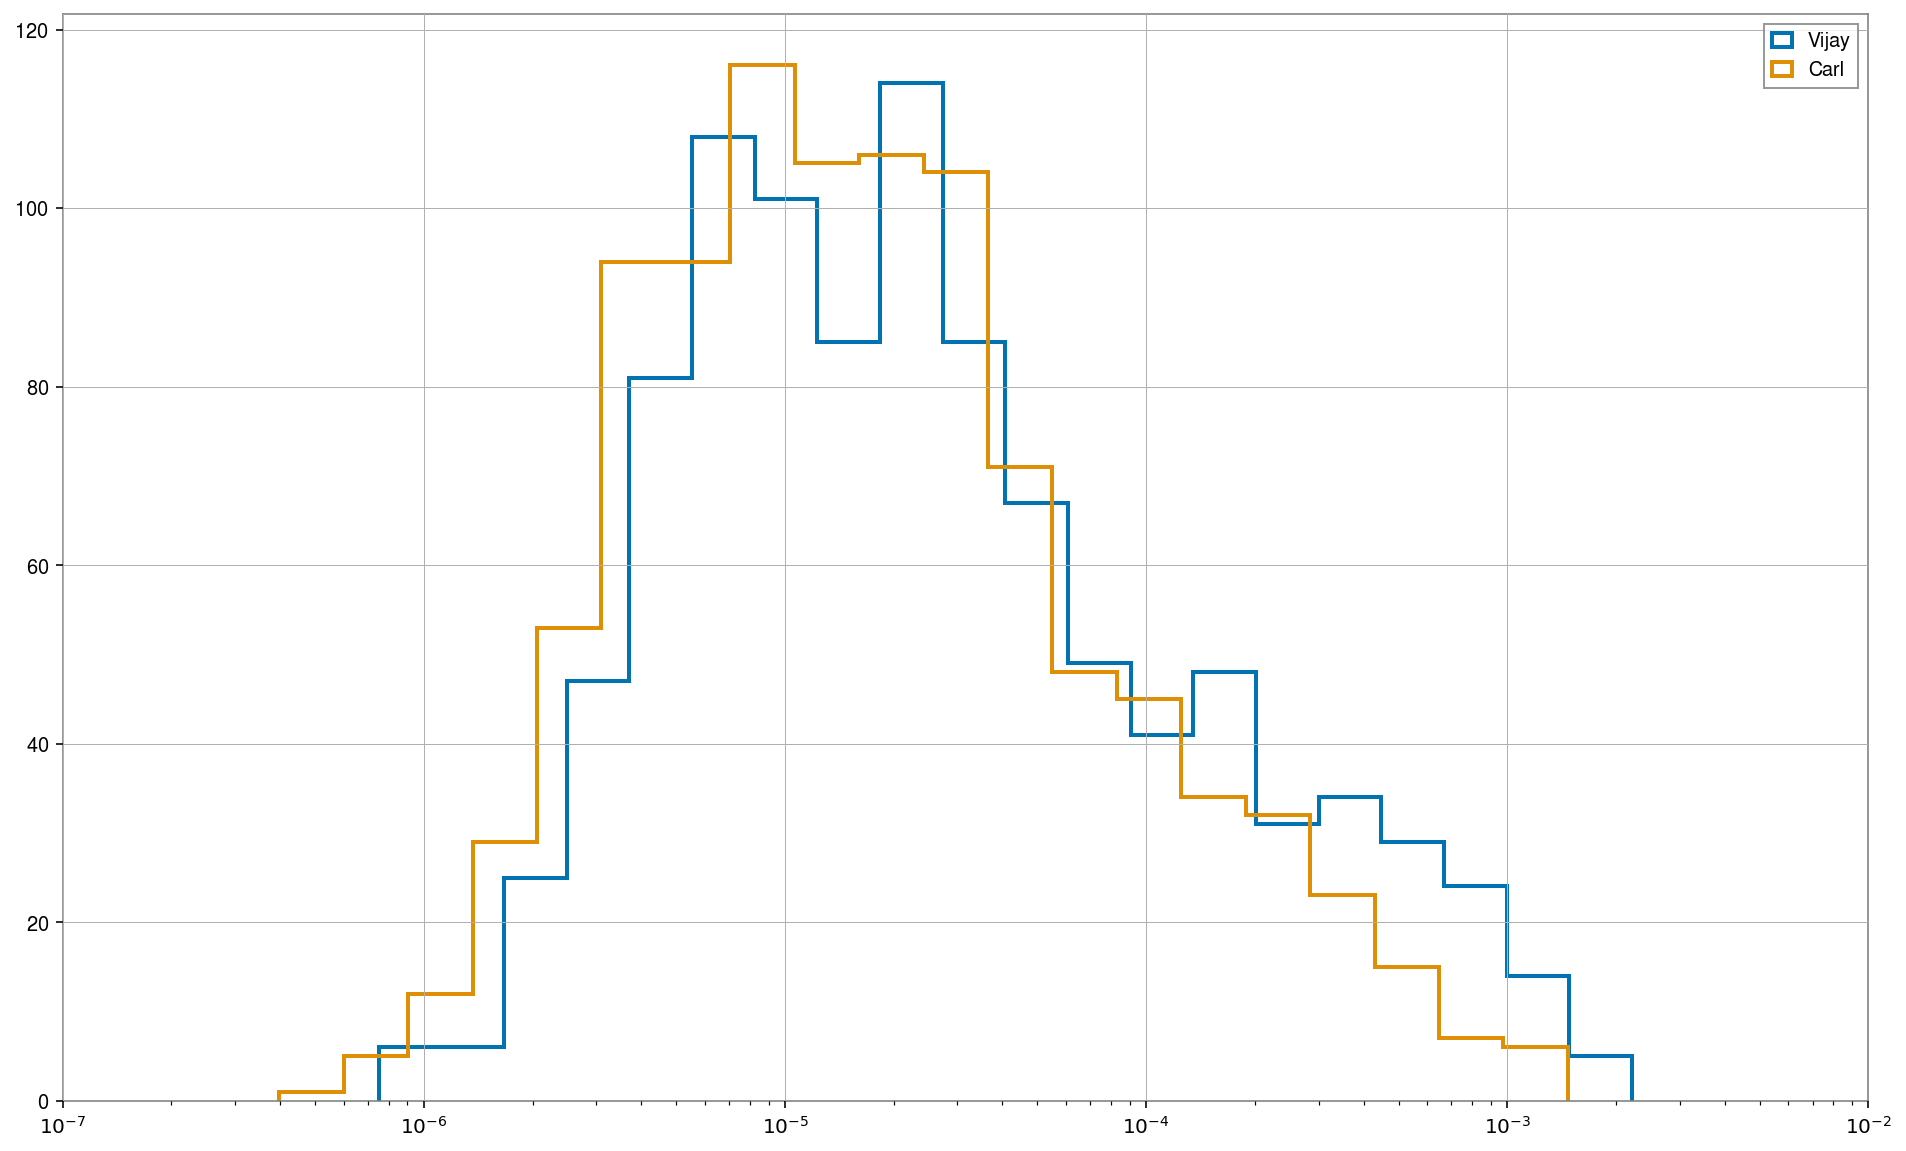

In [7]:
times = np.arange(0, 4, 1./4096.)
num = 1000

Full_WFs = np.zeros([num, len(times)], dtype=complex)
Marged_WFs = np.zeros([num, len(times)], dtype=complex)
MargedSparse_WFs = np.zeros([num, len(times)], dtype=complex)

simple_mm = []
simple_mmSparse = []

#for idx in range(num):
for idx in tqdm(range(num)):
    M = np.random.uniform(60, 100)
    q = np.random.uniform(1, 8)
    chi1 = [0, 0, np.random.uniform(-0.8, 0.8)]
    chi2 = [0, 0, np.random.uniform(-0.8, 0.8)]
    incl = np.arccos(np.random.uniform(-1,1))
    t, h, h_marg, h_margSparse = NRHybSur3dq8_marg(times, M, q, chi1, chi2, incl=incl)
    simple_mm.append(simple_mismatch(h, h_marg))
    simple_mmSparse.append(simple_mismatch(h, h_margSparse))
    Full_WFs[idx] = h
    Marged_WFs[idx] = h_marg
    MargedSparse_WFs[idx] = h_margSparse

fig, ax = plt.subplots(1,1,figsize=(10*1.61803398875,10))
n_bins = 20
minX, maxX = -7, -2   # log10
ax.set_xlim(minX, maxX)
given_xticks = np.array(range(minX,maxX+1))
set_logticks(fig, ax, given_xticks=given_xticks)
PlotHist(ax, simple_mm, n_bins, label='Vijay', color=cp[0], lw=2) 
PlotHist(ax, simple_mmSparse, n_bins, label='Carl', color=cp[1], lw=2) 
plt.legend()
plt.show()

In [8]:
def uniform_in_cos_angle(N,costheta_min=-1, costheta_max=1, offset=0.):
    return np.arccos(np.random.uniform(costheta_min,costheta_max,N)) + offset

def uniform_in_angle(N,theta_min=0., theta_max=2.*np.pi, offset=0.):
    return np.random.uniform(theta_min,theta_max,N) + offset

def innprod(h1, h2, freq, Sn):
    #print(h1.shape, h2.shape, freq.shape, Sn.shape)
    over = ne.evaluate('h1*complex(h2.real, -h2.imag)/Sn')
    integral = integrate.simps(over, freq)
    return 4.*integral.real

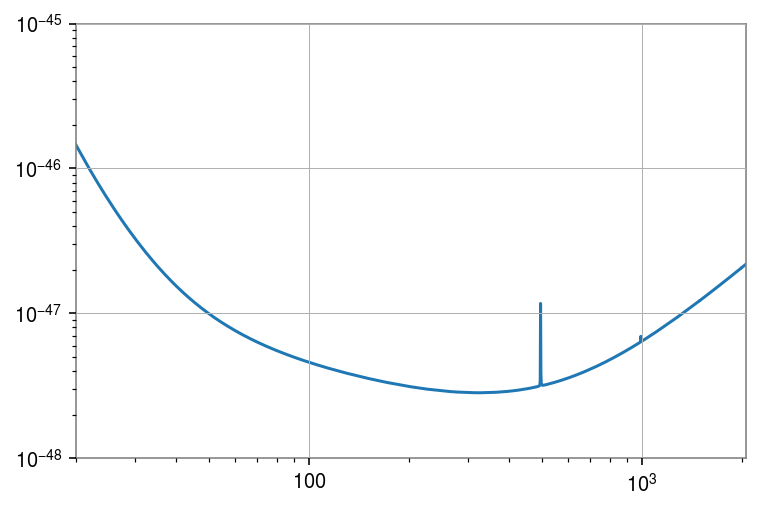

In [9]:
Aplus_asd = np.genfromtxt('/home/carl-johan.haster/projects/Waveform_marginalisation/Injection_data/PSDs/AplusDesign_filledIn.txt')

plt.loglog(Aplus_asd[:,0], np.square(Aplus_asd[:,1]))
plt.xlim(20, 2048)
plt.ylim(1e-48, 1e-45)
plt.show()

In [10]:
Nextrinsic = 50

IFO_cached = lal.CachedDetectors[lal.LALDetectorIndexLHODIFF]
gmst = lal.GreenwichMeanSiderealTime(1135136350.64)

Aplus_match = np.zeros([num, Nextrinsic])
Flat_match = np.zeros([num, Nextrinsic])

SparseAplus_match = np.zeros([num, Nextrinsic])
SparseFlat_match = np.zeros([num, Nextrinsic])

print(len(times))

16384


In [13]:
sampling_freq = 1/(times[1]-times[0])
minimum_freq = 20.

for i in tqdm(range(num)):
    
    Psi_samples = uniform_in_angle(Nextrinsic,theta_max=np.pi)

    RA_samples = uniform_in_angle(Nextrinsic)
    dec_samples = uniform_in_cos_angle(Nextrinsic,offset=-np.pi/2.)
    
    Full_WFplus_FFT, Full_WF_freq = nfft(Full_WFs[i].real, sampling_frequency=sampling_freq)
    Full_WFcross_FFT, Full_WF_freq = nfft(-Full_WFs[i].imag, sampling_frequency=sampling_freq)
    Marged_WFplus_FFT, Marged_WF_freq = nfft(Marged_WFs[i].real, sampling_frequency=sampling_freq)
    Marged_WFcross_FFT, Marged_WF_freq = nfft(-Marged_WFs[i].imag, sampling_frequency=sampling_freq)
    MargedSparse_WFplus_FFT, MargedSparse_WF_freq = nfft(MargedSparse_WFs[i].real, sampling_frequency=sampling_freq)
    MargedSparse_WFcross_FFT, MargedSparse_WF_freq = nfft(-MargedSparse_WFs[i].imag, sampling_frequency=sampling_freq)
    
    goodFreq_pick = np.logical_and(np.greater_equal(Full_WF_freq, minimum_freq), np.less(Full_WF_freq, sampling_freq/2))
    
    #print(len(Full_WF_freq), goodFreq_pick.sum())
    
    Aplus_PSD = np.interp(Full_WF_freq[goodFreq_pick], Aplus_asd[:,0], np.square(Aplus_asd[:,1]), left=1., right=1.)
    Flat_PSD = np.ones_like(Full_WF_freq[goodFreq_pick])*1e-47
    
    for j in range(Nextrinsic):
        
        F_plus, F_cross = lal.ComputeDetAMResponse(IFO_cached.response, RA_samples[j], dec_samples[j], Psi_samples[j], gmst)
        
        Full_WF_FFT = F_plus*Full_WFplus_FFT[goodFreq_pick] + F_cross*Full_WFcross_FFT[goodFreq_pick]
        
        Marged_WF_FFT = F_plus*Marged_WFplus_FFT[goodFreq_pick] + F_cross*Marged_WFcross_FFT[goodFreq_pick]
        
        MargedSparse_WF_FFT = F_plus*MargedSparse_WFplus_FFT[goodFreq_pick] + F_cross*MargedSparse_WFcross_FFT[goodFreq_pick]
        
        FullFull_Aplus = innprod(Full_WF_FFT, Full_WF_FFT, Full_WF_freq[goodFreq_pick], Aplus_PSD)
        MargedFull_Aplus = innprod(Marged_WF_FFT, Full_WF_FFT, Full_WF_freq[goodFreq_pick], Aplus_PSD)
        MargedMarged_Aplus = innprod(Marged_WF_FFT, Marged_WF_FFT, Full_WF_freq[goodFreq_pick], Aplus_PSD)
        MargedSparseFull_Aplus = innprod(MargedSparse_WF_FFT, Full_WF_FFT, Full_WF_freq[goodFreq_pick], Aplus_PSD)
        MargedSparseMargedSparse_Aplus = innprod(MargedSparse_WF_FFT, MargedSparse_WF_FFT, Full_WF_freq[goodFreq_pick], Aplus_PSD)
        
        Aplus_match[i,j] = MargedFull_Aplus/np.sqrt(FullFull_Aplus*MargedMarged_Aplus)
        SparseAplus_match[i,j] = MargedSparseFull_Aplus/np.sqrt(FullFull_Aplus*MargedSparseMargedSparse_Aplus)
        
        FullFull_Flat = innprod(Full_WF_FFT, Full_WF_FFT, Full_WF_freq[goodFreq_pick], Flat_PSD)
        MargedFull_Flat = innprod(Marged_WF_FFT, Full_WF_FFT, Full_WF_freq[goodFreq_pick], Flat_PSD)
        MargedMarged_Flat = innprod(Marged_WF_FFT, Marged_WF_FFT, Full_WF_freq[goodFreq_pick], Flat_PSD)
        MargedSparseFull_Flat = innprod(MargedSparse_WF_FFT, Full_WF_FFT, Full_WF_freq[goodFreq_pick], Flat_PSD)
        MargedSparseMargedSparse_Flat = innprod(MargedSparse_WF_FFT, MargedSparse_WF_FFT, Full_WF_freq[goodFreq_pick], Flat_PSD)
        
        Flat_match[i,j] = MargedFull_Flat/np.sqrt(FullFull_Flat*MargedMarged_Flat)
        SparseFlat_match[i,j] = MargedSparseFull_Flat/np.sqrt(FullFull_Flat*MargedSparseMargedSparse_Flat)

100%|██████████| 1000/1000 [12:20<00:00,  1.35it/s]


50000 1.0
50000 1.0


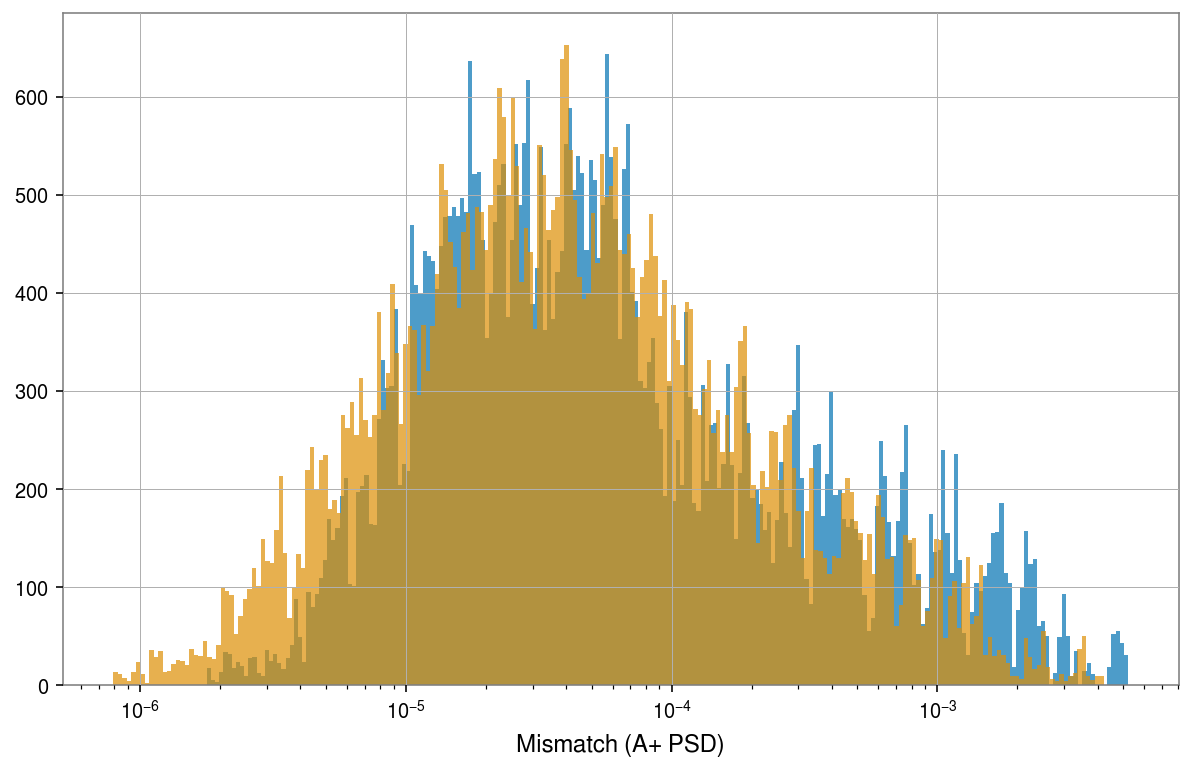

1.0 0.01
0.92806 0.001
0.67922 0.0001
1.0 0.01
0.96824 0.001
0.7224 0.0001


In [14]:
Aplus_hist_pick = np.less(1-Aplus_match.flatten(), 1)
print(Aplus_hist_pick.sum(), Aplus_hist_pick.sum()/(num*Nextrinsic))
SparseAplus_hist_pick = np.less(1-SparseAplus_match.flatten(), 1)
print(SparseAplus_hist_pick.sum(), SparseAplus_hist_pick.sum()/(num*Nextrinsic))

Aplus_hist_bins = np.logspace(np.log10(1-Aplus_match.flatten()[Aplus_hist_pick ]).min(), \
                              np.log10(1-Aplus_match.flatten()[Aplus_hist_pick ]).max(), int(np.sqrt(num*Nextrinsic)))

SparseAplus_hist_bins = np.logspace(np.log10(1-SparseAplus_match.flatten()[SparseAplus_hist_pick ]).min(), \
                              np.log10(1-SparseAplus_match.flatten()[SparseAplus_hist_pick ]).max(), int(np.sqrt(num*Nextrinsic)))



plt.figure(figsize=(10,10/1.61803398875))
plt.hist(1-Aplus_match.flatten()[Aplus_hist_pick], bins=Aplus_hist_bins , color=cp[0], label='Vijay', alpha=0.7)
plt.hist(1-SparseAplus_match.flatten()[SparseAplus_hist_pick], bins=SparseAplus_hist_bins , color=cp[1], label='Carl', alpha=0.7)
plt.xscale('log')
plt.xlabel('Mismatch (A+ PSD)')
plt.show()
#print(np.log10(1-Flat_matches.flatten()).min())
#print(np.log10(np.array([1, 1-Flat_matches.flatten().min()])))

print(np.less(1-Aplus_match.flatten()[Aplus_hist_pick ], 1e-2).sum()/(num*Nextrinsic), 1e-2)
print(np.less(1-Aplus_match.flatten()[Aplus_hist_pick ], 1e-3).sum()/(num*Nextrinsic), 1e-3)
print(np.less(1-Aplus_match.flatten()[Aplus_hist_pick ], 1e-4).sum()/(num*Nextrinsic), 1e-4)

print(np.less(1-SparseAplus_match.flatten()[SparseAplus_hist_pick ], 1e-2).sum()/(num*Nextrinsic), 1e-2)
print(np.less(1-SparseAplus_match.flatten()[SparseAplus_hist_pick ], 1e-3).sum()/(num*Nextrinsic), 1e-3)
print(np.less(1-SparseAplus_match.flatten()[SparseAplus_hist_pick ], 1e-4).sum()/(num*Nextrinsic), 1e-4)

50000 1.0
50000 1.0


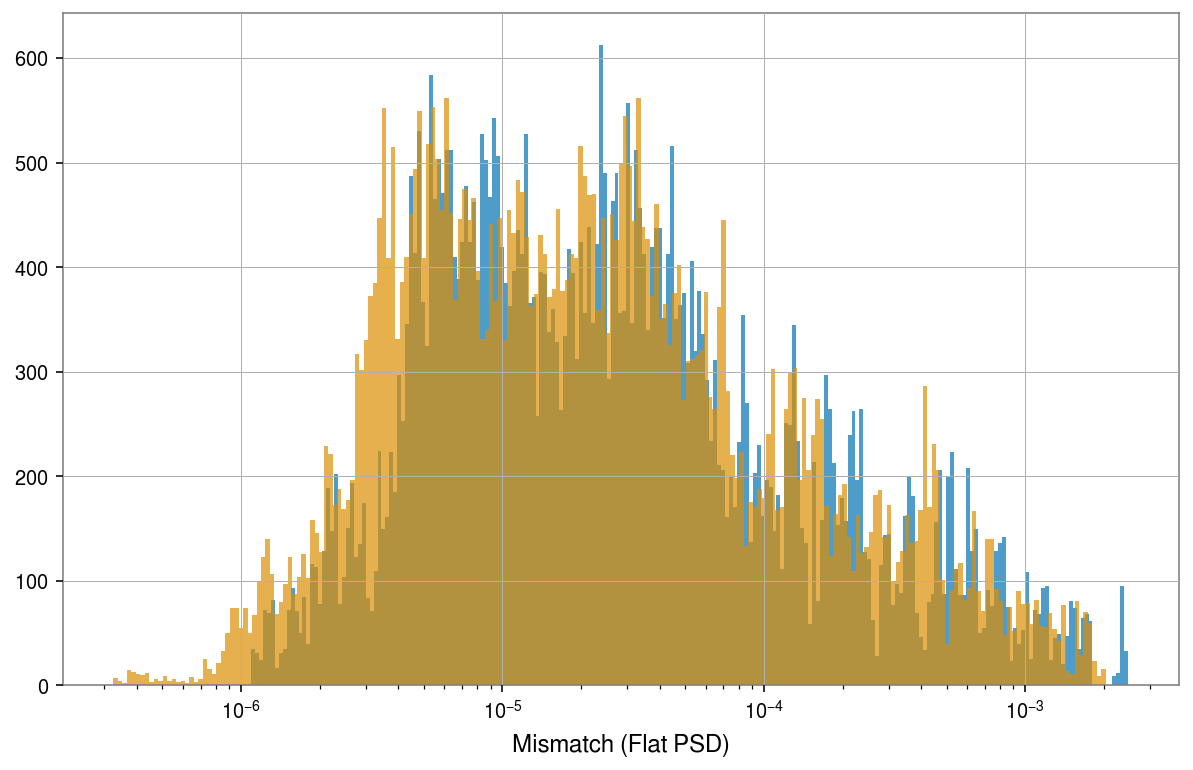

1.0 0.01
0.97638 0.001
0.78882 0.0001
1.0 0.01
0.98212 0.001
0.7973 0.0001


In [84]:
Flat_hist_pick = np.less(1-Flat_match.flatten(), 1)
print(Flat_hist_pick.sum(), Flat_hist_pick.sum()/(num*Nextrinsic))
SparseFlat_hist_pick = np.less(1-SparseFlat_match.flatten(), 1)
print(SparseFlat_hist_pick.sum(), SparseFlat_hist_pick.sum()/(num*Nextrinsic))

Flat_hist_bins = np.logspace(np.log10(1-Flat_match.flatten()[Flat_hist_pick ]).min(), \
                              np.log10(1-Flat_match.flatten()[Flat_hist_pick ]).max(), int(np.sqrt(num*Nextrinsic)))

SparseFlat_hist_bins = np.logspace(np.log10(1-SparseFlat_match.flatten()[SparseFlat_hist_pick ]).min(), \
                              np.log10(1-SparseFlat_match.flatten()[SparseFlat_hist_pick ]).max(), int(np.sqrt(num*Nextrinsic)))



plt.figure(figsize=(10,10/1.61803398875))
plt.hist(1-Flat_match.flatten()[Flat_hist_pick], bins=Flat_hist_bins , color=cp[0], label='Vijay', alpha=0.7)
plt.hist(1-SparseFlat_match.flatten()[SparseFlat_hist_pick], bins=SparseFlat_hist_bins , color=cp[1], label='Carl', alpha=0.7)
plt.xscale('log')
plt.xlabel('Mismatch (Flat PSD)')
plt.show()
#print(np.log10(1-Flat_matches.flatten()).min())
#print(np.log10(np.array([1, 1-Flat_matches.flatten().min()])))

print(np.less(1-Flat_match.flatten()[Aplus_hist_pick ], 1e-2).sum()/(num*Nextrinsic), 1e-2)
print(np.less(1-Flat_match.flatten()[Aplus_hist_pick ], 1e-3).sum()/(num*Nextrinsic), 1e-3)
print(np.less(1-Flat_match.flatten()[Aplus_hist_pick ], 1e-4).sum()/(num*Nextrinsic), 1e-4)

print(np.less(1-SparseFlat_match.flatten()[SparseFlat_hist_pick ], 1e-2).sum()/(num*Nextrinsic), 1e-2)
print(np.less(1-SparseFlat_match.flatten()[SparseFlat_hist_pick ], 1e-3).sum()/(num*Nextrinsic), 1e-3)
print(np.less(1-SparseFlat_match.flatten()[SparseFlat_hist_pick ], 1e-4).sum()/(num*Nextrinsic), 1e-4)

In [85]:
30 + 24.99+24.96 + 38.99 + (0.75*13.04) + 10.9 + 24.49

164.11